# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(y_train)

# TODO: number of testing examples
n_test = len(y_test)

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


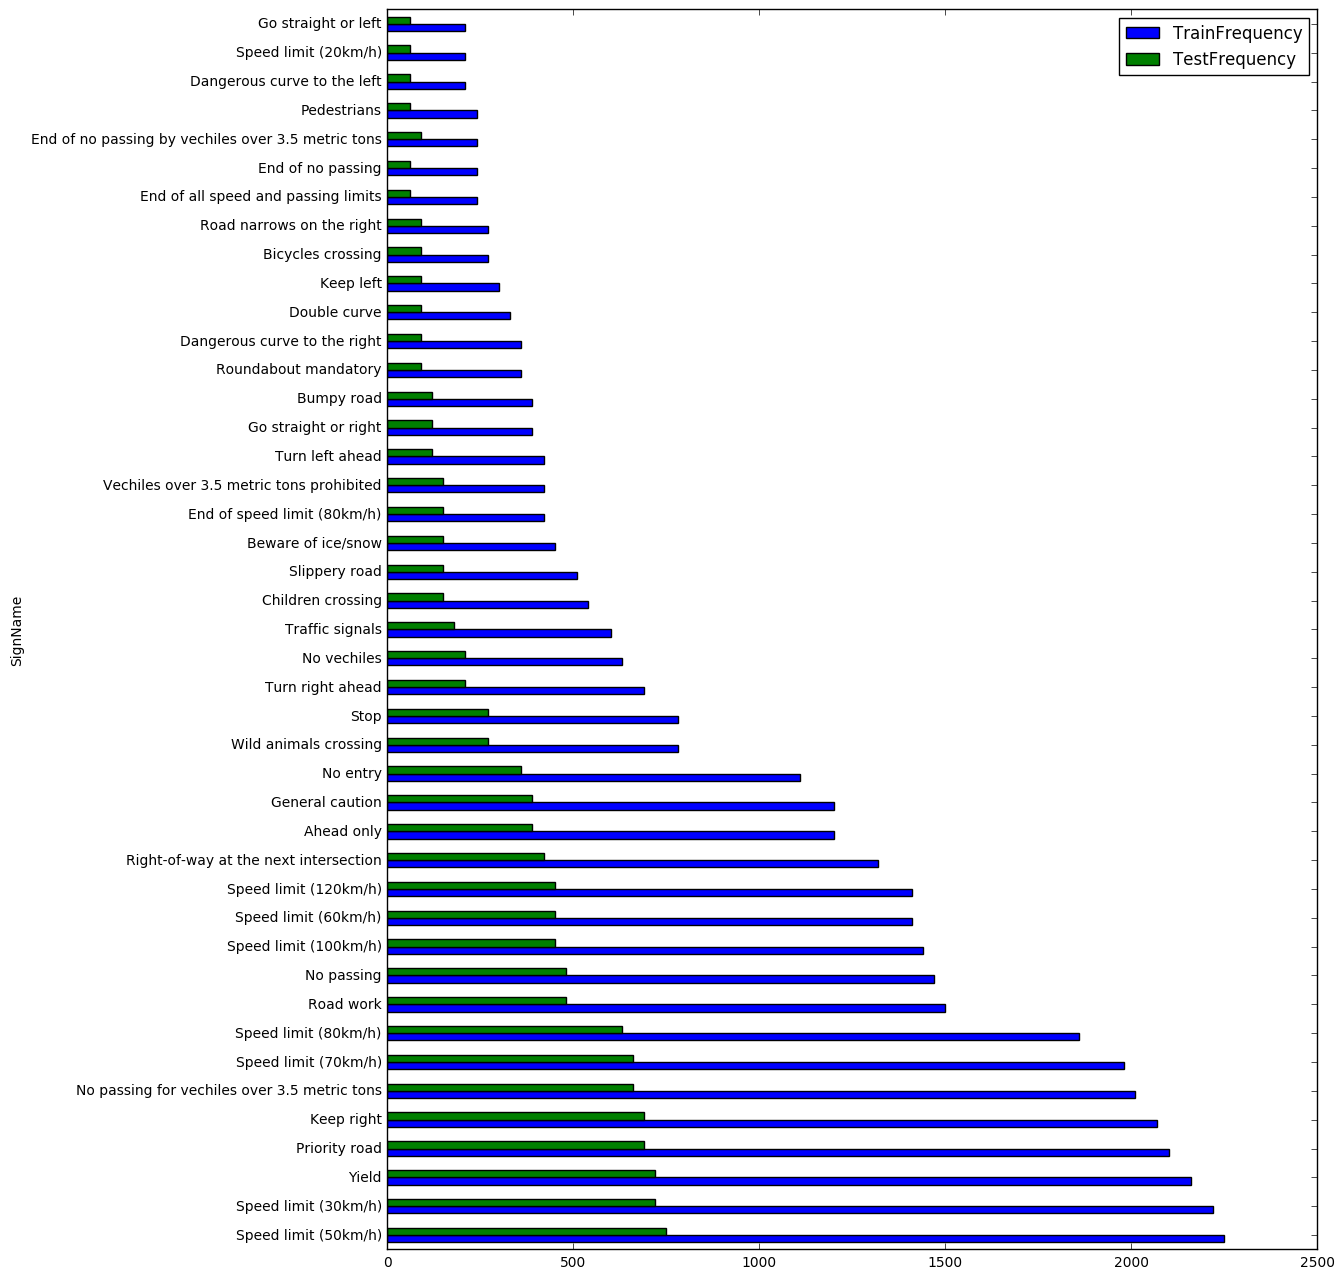

In [3]:
# Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

import pandas as pd
%matplotlib inline

# Let's look at the frequencies of roadsigns in the data, both for sanity checking and for seeing if the
# training examples are proportionate to the testing examples

# Build dataframe for labels
examples = pd.DataFrame(y_train, columns=["ClassId"])
lookup = pd.read_csv("signnames.csv")
examples = examples.merge(lookup, how="left", left_on="ClassId", right_on="ClassId")

# Create same type of dataframe for testing labels
tests = pd.DataFrame(y_test, columns=["ClassId"])
tests = tests.merge(lookup, how="left", left_on="ClassId", right_on="ClassId")
tests["TestFrequency"] = 1

# Groupby for frequency summary
labelfreq = examples.groupby(["SignName"]).count()
labelfreq.columns = ["TrainFrequency"]
labelfreq = labelfreq.join(tests.groupby(["SignName"])["TestFrequency"].count())
labelfreq = labelfreq.sort_values(by="TrainFrequency", ascending=False)

# Plot it
labelfreq.plot.barh(figsize=(12, 16))

Cool, looks like the training and testing examples have roughly proportionate frequencies. Including a bias in our model will be useful.

Also, many of the most frequently appearing signs are various speed limit signs, which matches what I would expect for a sanity check.

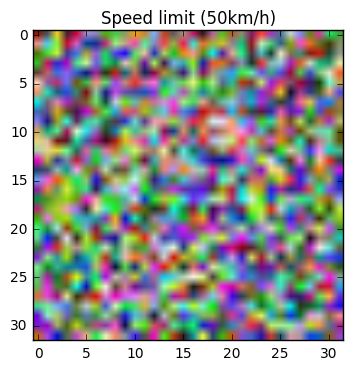

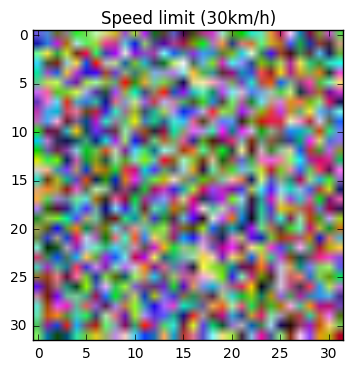

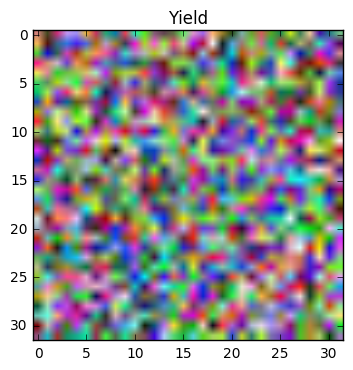

In [4]:
# Next I'm curious to see if anything meaningful comes from averaging examples together,
# Probably not because there's probably too much variety from image to image,
# but let's try it and see if we can detect any patterns.

# We'll just do the top three most common sign types

import numpy as np
import matplotlib.pyplot as plt

# Get indexes of each example type we're going to visualize
for signtype in labelfreq.head(n=3).index:
    indexes = examples[examples["SignName"]==signtype].index.tolist()

    # Slice and average the training examples
    trainslice = X_train[indexes].mean(axis=0)
    
    # Print the type of sign and draw the image
    plt.figure()
    plt.imshow(trainslice)
    plt.title(signtype)


Hmm, that definitely didn't produce the kind of patterns I was originally thinking of, but that is some good sureal abstract artwork. I see a panda in "Speed limit (50km/hr)", a koala in "Speed limit (30km/hr)", and an airplane in "Yield".

I've never tried averaging together pictures like that, or seen anyone else do it, so maybe it's just something that doesn't work out. I might have had better luck converting to greyscale before the averaging, or maybe these images are too varied to get anything meaningful from that way. At any rate, I'm just going to show a few random samples of the raw images as a sanity check and call it good on the exploration phase.

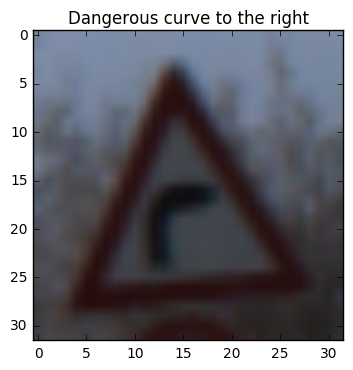

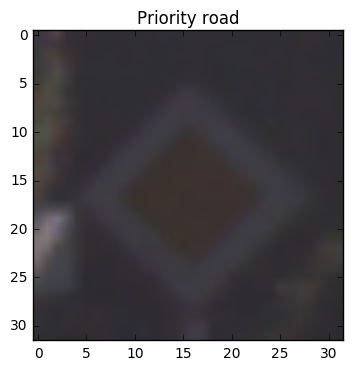

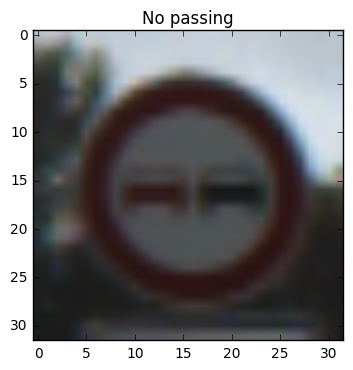

In [5]:
# Pull three random samples
samples = examples.sample(n=3)

# Show the images
for index, row in samples.iterrows():
    plt.figure()
    plt.imshow(X_train[index])
    plt.title(row["SignName"])

Great, looks like we have pictures. The labels seem correct too.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [6]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
import cv2

# Scale the pixel values to be between 0 and 1
def preprocess(image, dim3=True):
    
    # Convert to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
    image = clahe.apply(image)
    
    # Scale to be between 0 and 1
    image = image/255
    
    if dim3 is True:
        # Ensure shape
        image = np.reshape(image, [32, 32, 1])
    
    return image

# Construct the preprocessed x data
train_x = np.array([preprocess(image) for image in X_train], dtype=np.float32)
test_x = np.array([preprocess(image) for image in X_test], dtype=np.float32)

print("Preprocessing done.")

Preprocessing done.


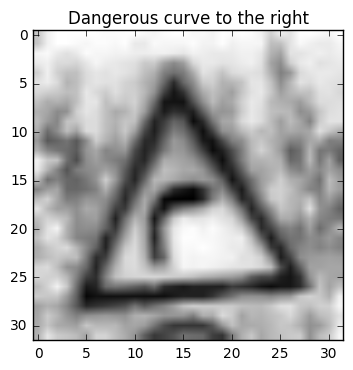

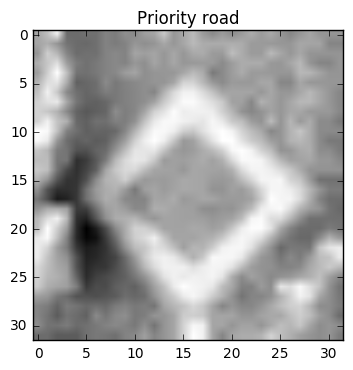

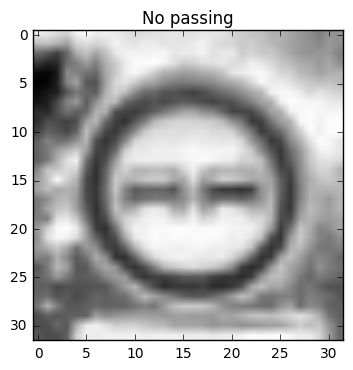

In [7]:
## Show the above samples with preprocessing applied
for index, row in samples.iterrows():
    plt.figure()
    image = preprocess(X_train[index], dim3=False)
    plt.imshow(image, cmap='gray')
    plt.title(row["SignName"])

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

For my preprocessing steps, I'm converting the images to grayscale, adjusting the contrast by a method called CLAHE, and scaling my pixel values to be between 0 and 1. CLAHE stands for Contrast Limited Adaptive Histogram Equalization, which basically adjusts little sections of the image to a more suitable contrast at a time. The advantage over plain Adaptive Histogram Equalization is intended to be that noise from the background isn't as likely to overwhelm the adjustments.

In [8]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

# Finalize datasets
train_y = pd.get_dummies(y_train).astype(float).values
test_y = pd.get_dummies(y_test).astype(float).values

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

All I'm doing here is converting the labels to one-hots. I've decided not to generate additional data, mostly to save on computing resources.

In [9]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf

def model(x, w_c1, w_c2, w_h, w_o, bias, p_keep_conv, p_keep_hidden):
    
    # Convolutional layer 1, output shape = (None, 14, 14, 24)
    x = tf.nn.relu(tf.nn.conv2d(x, w_c1, strides=[1, 1, 1, 1], padding="VALID"))
    x = tf.nn.avg_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], "VALID")
    x = tf.nn.dropout(x, p_keep_conv)

    # Convolutional layer 2, output shape = (None, 5, 5, 48)
    x = tf.nn.relu(tf.nn.conv2d(x, w_c2, strides=[1, 1, 1, 1], padding="VALID"))
    x = tf.nn.avg_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], "VALID")
    x = tf.nn.dropout(x, p_keep_conv)
    
    # Reshape for hidden, output shape = (None, 1200)
    x = tf.reshape(x, [-1, 5*5*48])
    
    # Hidden layer 1, output shape = (None, 720)
    x = tf.nn.relu(tf.matmul(x, w_h))
    x = tf.nn.dropout(x, p_keep_hidden)
    
    # Output layer, shape (None, 43)
    x = tf.add(tf.matmul(x, w_o), bias)

    return x

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

First layer: 5x5 VALID convolution with 24 filters, which then passes through a relu activiation function. Next I decided to apply a 2x2 average pooling, and finally I apply dropout with 80% chance to keep.

Second layer: exactly the same as the first layer, except this time with 48 filters.

Third layer: Fully connected layer, with 720 outputs (60% of the flattened inputs). Also uses a relu activation function. A dropout with 50% chance to keep follows.

Output layer: Just a linear node with bias.

In [10]:
# Important note - Restoring the saved model only works after restarting the jupyter notebook kernel

### Train your model here.
### Feel free to use as many code cells as needed.
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

# Define input placeholders
x = tf.placeholder(tf.float32, [None, 32, 32, 1])
y = tf.placeholder(tf.float32, [None, 43])
p_keep_conv = tf.placeholder("float")
p_keep_hidden = tf.placeholder("float")

# Define weights and bias variables
w_c1 = tf.Variable(tf.random_normal([5, 5, 1, 24], stddev=0.01), name="w_c1")
w_c2 = tf.Variable(tf.random_normal([5, 5, 24, 48], stddev=0.01), name="w_c2")
w_h = tf.Variable(tf.random_normal([1200, 720], stddev=0.01), name="w_h")
w_o = tf.Variable(tf.random_normal([720, 43], stddev=0.01), name="w_o")
bias = tf.Variable(tf.to_float(train_y.mean(axis=0)), name="bias")

# Define model, cost, training op
fx = model(x, w_c1, w_c2, w_h, w_o, bias, p_keep_conv, p_keep_hidden)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(fx, y))
train_op = tf.train.AdamOptimizer().minimize(cost)

# Define saver and saver variables
saver = tf.train.Saver()
best = 0.0
count = 0
restore = True

# Start session
with tf.Session() as sess:
    
    # Init variables
    tf.initialize_all_variables().run()
    
    # Restore a saved model if set to do so
    if restore is True:
        saver.restore(sess, "model.ckpt")
        print("Restored saved model.")
    else:
        print("Starting new model.")
    
    # Set number of epochs to run, 0 means no more training
    for n in range(0):
    
        # Shuffle the data
        train_x, train_y = shuffle(train_x, train_y)

        # Divide the data into batches
        batchsize = 128
        for start, end in zip(range(0, len(train_x), batchsize), range(batchsize, len(train_x) + 1, batchsize)):

            # Train on the batch
            sess.run(train_op, feed_dict={x: train_x[start:end], y: train_y[start:end], p_keep_conv: 0.8, p_keep_hidden: 0.5})
            
        # Report the accuracy
        predicts = sess.run(tf.argmax(fx, 1), feed_dict={x: test_x, p_keep_conv: 1.0, p_keep_hidden: 1.0})
        accuracy = accuracy_score(np.argmax(test_y, axis=1), predicts)
        print("Accuracy score:", accuracy)
        
        # If the accuracy is an improvement, save the model
        if accuracy > best:
            best = accuracy
            count = 0
            saver.save(sess, "model.ckpt")
        
        # If not an improvement, add a count
        else:
            count += 1
            
        # If count is too large, break training
        if count >= 10:
            print("Training done.")
            break
        

Restored saved model.


In [11]:
# Do a final test

with tf.Session() as sess:

    # Init variables
    tf.initialize_all_variables().run()
    
    # Restore saved weights
    saver.restore(sess, "model.ckpt")
    
    # Report the testing accuracy
    predicts = sess.run(tf.argmax(fx, 1), feed_dict={x: test_x, p_keep_conv: 1.0, p_keep_hidden: 1.0})
    accuracy = accuracy_score(np.argmax(test_y, axis=1), predicts)
    print("Accuracy score:", accuracy)

Accuracy score: 0.967775138559


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I ended up using AdamOptimizer, with a batch size of 128, and a maximum of 100 epochs during training. At the end of each epoch, testing accuracy gets reported. If the current model's accuracy is the highest so far, a model checkpoint gets saved. If 10 epochs go by without improvement, the training is halted.


### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

I started off with 3, 3x3 SAME convolutional layers, wrapped in relus, followed by max pooling and dropout. One fully connected layer. One output layer.

It performed terrible. I started playing around with all sorts of architectures. A lot of them just bogged my computer. At one point I had a chain of 7 convolutional layers going on. I tried my hand at creating an inception module, which I don't think I implimented right.

Still nothing was working, so I switched gears. I set up my model architecture as a simple linear unit and started concentrating on getting an accuracy score of anything higher than 5%, which had been my limit so far. When my simple model still wasn't pulling it off, I took a day off and had a long hard think about things.

I came back and fixed my preprocessing. I'd forgotten to scale my input values to be between 0 and 1.

I went back to my original architecture, and it worked fine. But the training was slow. By this point I was getting a pretty good idea of what scale of model would cause my computer to bite the dust. I'd also reflected on a few points:

* These signs must be colorblind safe. Not to mention, by far the predominant sign would be speed limit signs, which have no colors anyways. So grayscale makes a lot of sense for this problem.
* These signs seem generally very well centered in this dataset. Since most of what we care about isn't near the edges of the frames, VALID convolutions make a lot of sense. 
* If I'm using VALID convolutions anyways, why not use average pooling instead of max pooling, which might preserve more information?
* And if I'm using VALID convolutions, 5x5 filter frames divide in nicely with no wasted pixel values

So I tightened up my parameters and exerienced very little accuracy loss for it. My new convolutional average pooling layers reduced my image hight and width dimensions too quickly to have a third 5x5 convolutional average pooling layer, so I also experimented with a convolutional layer with no average pooling. I tried a 1x1 convolutional for a little dimensionality reduction before my fully connected layer, which I was excited to try after the mentions in the lectures, but it didn't succeed in any gains. I also experimented with having two fully connected hidden layers, but couldn't see any point to that either.

Finally, I experimented with using a gradient descent optimizer with learning rate decay instead of an adam optimizer. I ended up sticking with adam optimizer for its big reduction in required training epochs, but I think that if I was concerned with that last little percentage of accuracy gain, I'd go back to using just a plain gradient decent optimizer.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

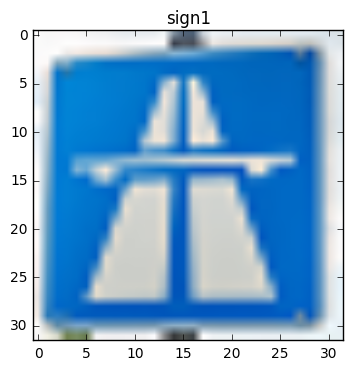

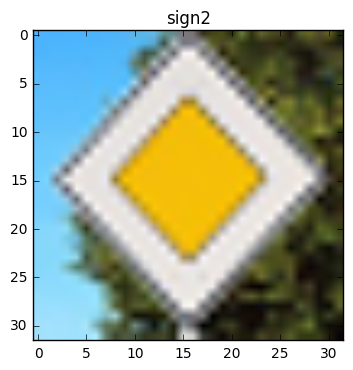

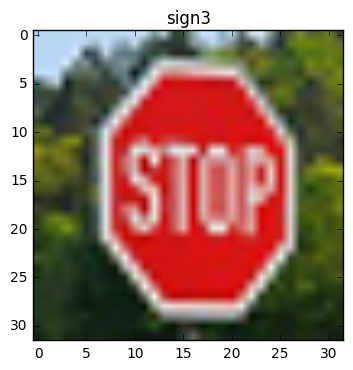

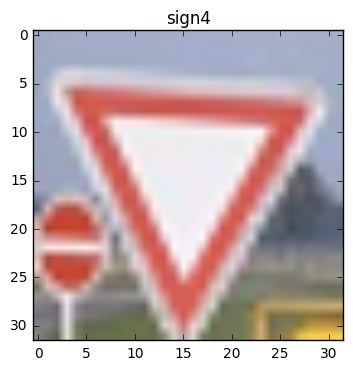

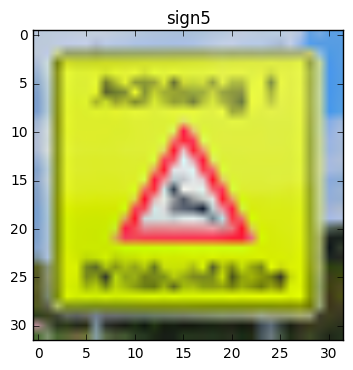

In [12]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
from scipy.misc import imread

test_images = []

for i in range(5):
    
    # Load the image
    fileloc = "test_images/sign{}.png".format(i+1)
    image = imread(fileloc)
    
    # Plot the raw image
    plt.figure()
    plt.imshow(image)
    plt.title("sign{}".format(i+1))
    
    #Preprocess and store in array
    image = preprocess(image)
    test_images.append(image)

test_images = np.array(test_images)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

My first two signs should hopefully be straightforward. The third sign is at a bit of an angle, so it might be a bit more challenging. The fourth sign has a different kind of sign in the background, which should be interesting. And the fifth sign isn't one of the training examples, but it has the same icon as the animal crossing training examples... so we'll see!

In [13]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

# Prep dictionary for answer key
lookupdict = lookup.set_index("ClassId")["SignName"].to_dict()

# Start session
with tf.Session() as sess:
    
    # Init variables
    tf.initialize_all_variables().run()
    
    # Restore weights
    saver.restore(sess, "model.ckpt")
    
    # Make predictions
    predicts = sess.run(tf.argmax(fx, 1), feed_dict={x: test_images, p_keep_conv: 1.0, p_keep_hidden: 1.0})
    
    # Key the predictions
    predicts = [lookupdict[i] for i in predicts]

# Format the predictions
predicts = pd.DataFrame(predicts, columns=["Prediction"])
predicts.index = ["Sign{}".format(i+1) for i in range(5)]
print(predicts)

                 Prediction
Sign1       Traffic signals
Sign2         Priority road
Sign3                  Stop
Sign4                 Yield
Sign5  Speed limit (50km/h)


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset?_

**Answer:**

Looks like it got three out of the five. Surprisingly, it got the first one wrong. Not surprisingly, it also got the last one wrong, which wasn't in the training set.

EDIT: Actually, I'm not sure if the first sign type is in the dataset either? I think this one means the start of the autobahn, which I can't find in this training set.

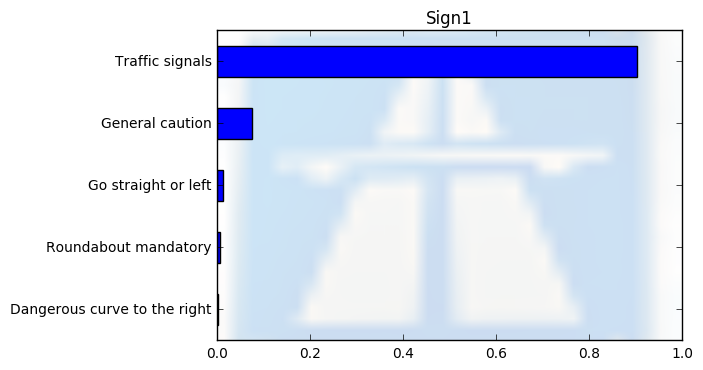

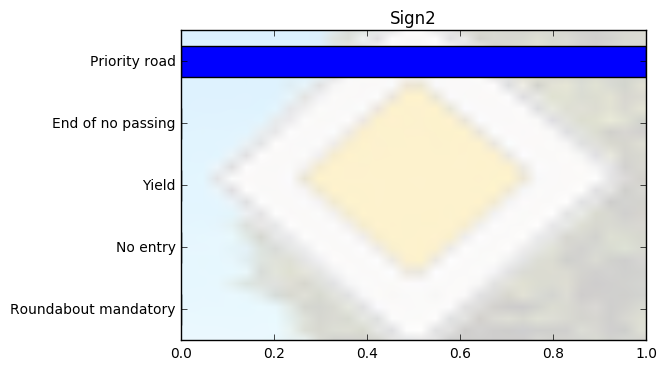

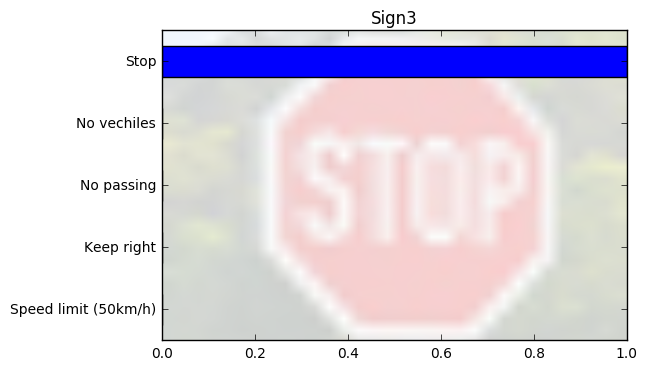

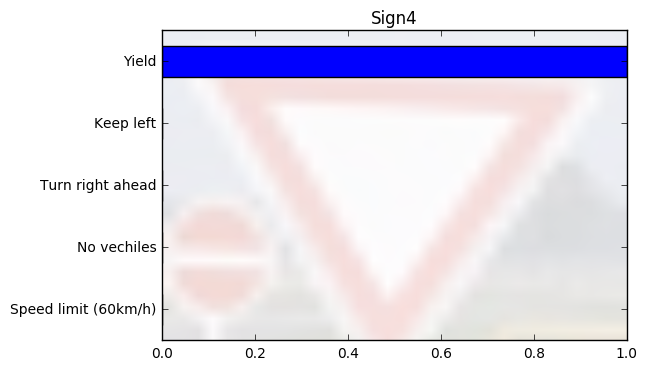

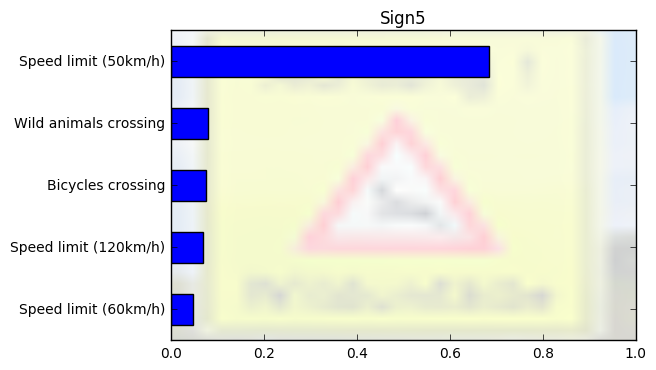

In [14]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

# Start session
with tf.Session() as sess:
    
    # Init variables
    tf.initialize_all_variables().run()
    
    # Restore weights
    saver.restore(sess, "model.ckpt")
    
    # Make softmax predictions
    softs = sess.run(tf.nn.softmax(fx), feed_dict={x: test_images, p_keep_conv: 1.0, p_keep_hidden: 1.0})

# Convert to dataframe
softs = pd.DataFrame(softs)

# Key the column headers
softs.columns = [lookupdict[i] for i in softs.columns.values]

# Iterate through and plot each
for index, row in softs.iterrows():
    plt.figure()
    row.sort_values()[-5:].plot.barh(title="Sign{}".format(index+1))
    plt.imshow(imread("test_images/sign{}.png".format(index+1)), alpha=0.2, aspect="auto", extent=(0, 1, -1, 5))


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

Wow, awesome. My classifier is spot on certain about the three signs that that it recognizes.

For the animal crossing sign, Sign5, the correct answer is at least the second runner up, but pretty far back on probabilities. Still understandable, because the sign isn't technically inside the training set.

For Sign1, I'm pretty certain now that there also were no training examples of the autobahn start / highway start. So maybe the classifier is doing okay here.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

Nothing fancy going on here for me, I think. I've just saved a model checkpoint through Tensorflow's built in Saver class, and I reload the model each time I'm going to use it to make predictions.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

## 